# Tagtog에서 annotation 파일 다운 받기

In [ ]:
import json
import glob
import re
import os
import pandas as pd
import requests
import zipfile
import shutil
import html

In [47]:
#로그인 위치
url = "https://tagtog.net/-login"

#다운로드 위치
file_url = 'https://tagtog.net/leegi/relation_extraction/-downloads/dataset-as-anndoc' 
o_file = 'abc.zip'  
if os.path.exists(o_file):
    os.remove(o_file)

#로그인 정보
#log_info.json file로부터 아이디(계정) 비밀번호 받아오기
with open("log_info.json","r") as f:
    log_info = json.load(f)
login_info = {
    'loginid' : log_info["login_id"],
    'password' : log_info["login_pw"],
}
#로그인
with requests.Session() as s:
    login_req = s.post(url, data=login_info)

    # #download annotation zip file from tagtog.net
    r = s.get(file_url)

    with open(o_file,"wb") as output:
        output.write(r.content)

In [48]:
#압축파일 풀기
folder_path = "./tagtog_relation_extraction/"

zip_ = zipfile.ZipFile("abc.zip")
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
zip_.extractall(folder_path)


# annotation 결과 전처리

In [8]:
#폴더 경로
folder_name = "./tagtog_relation_extraction/relation_extraction/"

#context list
context_name_list = os.listdir(folder_name + "ann.json/master/pool")

#relation 폴더 경로
relation_folder_paths = glob.glob(folder_name + "ann.json/master/pool/*")

#context 폴더 경로
# contexts_folders_paths = glob.glob(folder_name + "plain.html/pool/*")
contexts_folders_paths = [folder_name + "plain.html/pool/" + c for c in context_name_list]


#anntation_lenged 정보
annotation_legend = folder_name + "annotations-legend.json"
with open(annotation_legend,"r") as f:
    annotation_legend = json.load(f)
#relation dictionary 파일로부터 subject와 object의 entity 정보를 추출해주는 함수
def get_needed_relation_data(tmp_relation):
    subject_token = re.findall("\(+(.+)+\)",annotation_legend[tmp_relation["relations"][0]['classId']])[0].split("|")[0]
    if subject_token == tmp_relation['entities'][0]['classId']:
        sub_entity, obj_entity = tmp_relation['entities']
    else:
        obj_entity, sub_entity  = tmp_relation['entities']
    
    # get preprocessed entities
    def _get_entity(entity):
        outputs = entity['offsets'][0]
        outputs['type'] = annotation_legend[entity['classId']].split("-")[1].lower()
        return outputs
    
    output_subject = _get_entity(sub_entity)
    output_object = _get_entity(obj_entity)
    return output_subject, output_object


#relation dictionary 파일로부터 title(relation)을 추출해주는 함수
def get_label(relation_json):
    label_tag = relation_json['relations'][0]['classId'] #r_6
    try:
        _,sub_type, label = annotation_legend[re.findall("\(+(.+)+\|",annotation_legend[label_tag])[0]].split("-")
        return f"{sub_type}:{label}"
    except:
        _,sub_type, = annotation_legend[re.findall("\(+(.+)+\|",annotation_legend[label_tag])[0]].split("-")
        return f"{sub_type}:no_relation"


#html 파일로부터 text만 추출해주는 함수
def get_context_from_html(html_file):
    html_file = re.sub(r"\n","", html_file)
    html_file = html.unescape(html_file)
    return re.findall("(<pre.+>)(.+)(</pre>)",html_file)[0][1]


#entity 정보가 포함된 sentence를 생성해주는 함수
def get_sentence_with_entites(subject_entity, object_entity, sentence):
    if subject_entity['start'] < object_entity['start']:
        entity1,entity2 = subject_entity, object_entity
    else:
        entity1,entity2 = object_entity, subject_entity
    
    #entity 시작 위치 및 길이 
    ett1_stt, ett1_len = entity1['start'], len(entity1['text'])
    ett2_stt, ett2_len = entity2['start'], len(entity2['text'])
    
    #문장 분리
    bf, ett1, mid, ett2, af = sentence[:ett1_stt], \
                            sentence[ett1_stt:ett1_stt+ett1_len], \
                            sentence[ett1_stt+ett1_len:ett2_stt], \
                            sentence[ett2_stt:ett2_stt+ett2_len], \
                            sentence[ett2_stt+ett2_len:]

    
    if subject_entity['start'] < object_entity['start']:
        ett1,ett2 = f"<sbj:{ett1}>", f"<obj:{ett2}>"
    else:
        ett1,ett2 = f"<obj:{ett1}>", f"<sbj:{ett2}>"
    
    return "".join([bf, ett1, mid, ett2, af])


In [9]:
#dataframe column
# id : context title(e.g : 카카오게임, 11번가 등)
# sentence w/o entity
# sentence w entity
# subject_entity
# object_entity
# class

id_list = []
sentence_list = []
sentence_with_entities_list = []
subject_entity_list = []
object_entity_list = []
relation_list = []


# tagtog 데이터를 CSV 형태로 변경
for context_name, relation_folder, contexts_folder in zip(context_name_list, relation_folder_paths, contexts_folders_paths):
    # relation files와 context files 리스트 출력
    file_ids = [file_name.split(".txt.")[0] for file_name in os.listdir(relation_folder)]
    file_nums = [ids.split("-")[1] for ids in file_ids]
    relation_files = [relation_folder + "/"+ file_id + ".txt.ann.json" for file_id in file_ids]
    context_files = [contexts_folder + "/"+ file_id + ".txt.plain.html" for file_id in file_ids]
    
    #json으로 된 relation data와 html로 된 context 데이터 읽기
    for relation_file, context_file, file_num in zip(relation_files,context_files, file_nums):
        
        #subject, object 정보 추출
        with open(relation_file, "r") as f:
            relation_json = json.load(f)
        try:
            tmp_subject, tmp_object = get_needed_relation_data(relation_json) #subject, object
            tmp_label = get_label(relation_json)
        except:
            continue
        
        #sentence, sentence with entities 정보 추출
        with open(context_file, "r") as f:
            context_json = f.read()
        tmp_sentence = get_context_from_html(context_json)
        tmp_sentence_w_entities = get_sentence_with_entites(tmp_subject,tmp_object,tmp_sentence)
        
        #각 list에 데이터 저장
        id_list.append(f"{context_name}_{file_num}")
        sentence_list.append(tmp_sentence)
        sentence_with_entities_list.append(tmp_sentence_w_entities)
        subject_entity_list.append(tmp_subject)
        object_entity_list.append(tmp_object)
        relation_list.append(tmp_label.lower())


In [25]:
# class 통합
class_dict = {
    "org:location" : "location",
    "per:place_of_birth" : "location",
    "org:related" : "related",
    'per:coworker' : "related",
    'per:alternate' : "alternate",
    'org:alternate' : "alternate",
    'org:product' : "product",
    'per:product' : 'product',
    'org:no_relation' : "no_relation",
    'per:no_relation' : "no_relation",
    'poh:no_relation' : "no_relation"
}
relation_list = list(map(lambda x : class_dict[x] if x in class_dict.keys() else x, relation_list))

# 전처리 결과를 Google Sheet으로 옮기기

In [51]:
# google sheet와 연결
# 참고 자료 : https://pbj0812.tistory.com/184

# !pip install gspread
# !pip install oauth2client

import gspread
from oauth2client.service_account import ServiceAccountCredentials

scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

#json key file 위치
json_file_name = './stable-house-327308-c4a6a7447abd.json'

# json key file을 이용하여 접속
credentials = ServiceAccountCredentials.from_json_keyfile_name(json_file_name, scope)
gc = gspread.authorize(credentials)

#구글 스프레드 시트 주소
spreadsheet_url = "https://docs.google.com/spreadsheets/d/1Zfhy3xh-2or5dUsSRm9d3yIN4Jhaleh32Rxqejy8hbI/edit#gid=0"

# 스프레드시트 문서 가져오기
doc = gc.open_by_url(spreadsheet_url)
## gc.create(spreadsheet_name) # 스프레드시트 생성


#시트 선택하기
sheet_name = "annotation"

#해당 시트가 있는 경우 불러오기
cy = doc.worksheet("창용")
sh = doc.worksheet("상하")
ys = doc.worksheet("유석")
mc = doc.worksheet("명철")
gs = doc.worksheet("기성")
yb = doc.worksheet("예빈")
bj = doc.worksheet("범진")
worksheet = doc.worksheet(sheet_name)
## 403 error가 뜰 경우, google sheets API를 활성시켜줘야 함


In [27]:
# # 특정 셀 데이터 가져오기
# print("특정 셀 데이터 가져오기:",worksheet.acell("B1").value)

# # 행 데이터 가져오기
# print("행 데이터 가져오기:",worksheet.row_values(1))

# # 열 데이터 가져오기
# print("행 데이터 가져오기:",worksheet.col_values(1))

# # 특정 영역 선택하여 가져오기
# range_list = worksheet.range("A1:D1")
# print("영역 데이터 가져오기:",[cell.value for cell in range_list])
# # 특정 셀에 데이터 쓰기
# worksheet.update_acell("A1","ids")

# # 행으로 데이터 추가하기
# worksheet.append_row([1,2,3,4])

# # 특정 index 행에 데이터 추가
# worksheet.insert_row([1,2,3,4], 10)


In [28]:
# 시트의 모든 데이터 가져오기
values = worksheet.get_all_values()
header, rows = values[0], values[1:]
data = pd.DataFrame(rows, columns=header)

column_list = ["id","sentence","sentence_with_entity","subject_entity","object_entity","class"]
data = data[column_list]
data.head()

sen_list =  list(data.sentence_with_entity.values)
len(sen_list)
#각 sheet의 cell을 업데이트하는 방식
for el in [
    worksheet,
    cy,sh,ys,mc,gs,yb,bj
    ]:
    el.resize(len(id_list)+1,10)
    list_range = f"a2:f{len(id_list)+1}"
    cell_list = el.range(list_range)
    
    for i in range(len(cell_list)//len(column_list)):
        cell_list[(6*i)].value = id_list[i]
        cell_list[(6*i)+1].value = sentence_list[i]
        cell_list[(6*i)+2].value = sentence_with_entities_list[i]
        cell_list[(6*i)+3].value = str(subject_entity_list[i])
        cell_list[(6*i)+4].value = str(object_entity_list[i])
        cell_list[(6*i)+5].value = relation_list[i]

    el.update_cells(cell_list)


# # pandas dataframe을 sheet에 입력하는 방식
# # from gspread_dataframe import set_with_dataframe
# data = pd.DataFrame(
#     {'id':id_list,
#     'sentence':sentence_list,
#     'sentence_with_entity':sentence_with_entities_list,
#     'subject_entity':subject_entity_list,
#     'object_entity':object_entity_list,
#     'class':relation_list,
#     'work1':[0]*len(id_list),
#     'Data Error':[0]*len(id_list)
#     }
# )
# set_with_dataframe(cy,data)
# set_with_dataframe(sh,data)
# set_with_dataframe(ys,data)
# set_with_dataframe(mc,data)
# set_with_dataframe(gs,data)
# set_with_dataframe(yb,data)
# set_with_dataframe(bj,data)
# set_with_dataframe(worksheet,data)


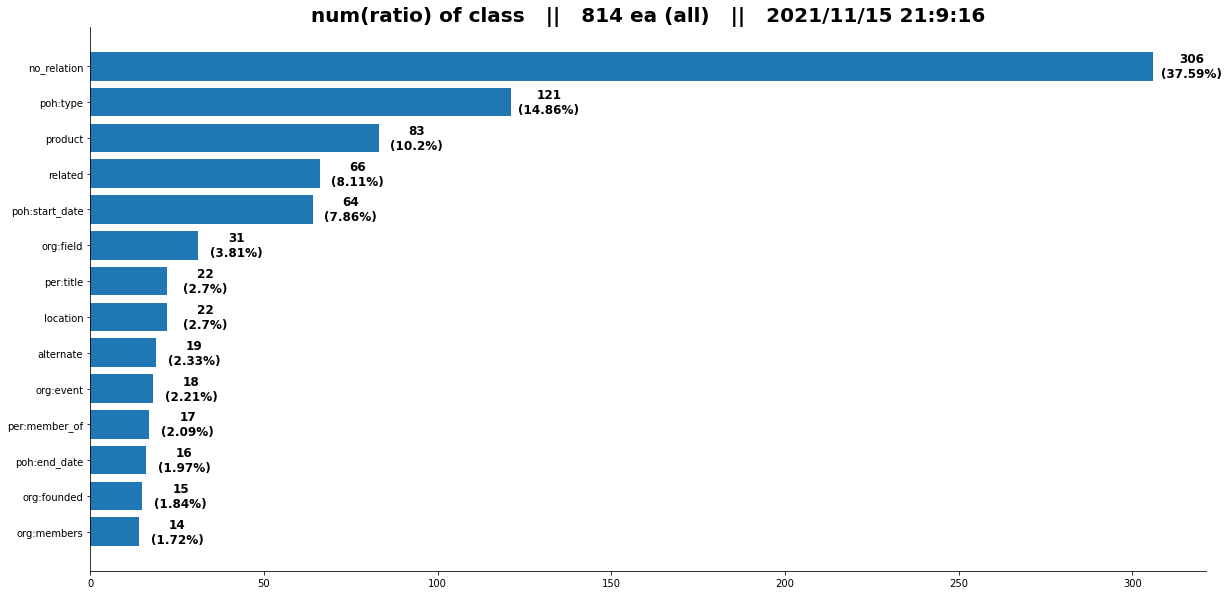

In [306]:
from pytz import timezone
from datetime import datetime
today = datetime.now(timezone('Asia/Seoul'))
time_now = "%s/%s/%s %s:%s:%s" %(today.year, today.month,today.day,today.hour, today.minute, today.second)

# !pip install seaborn
# !pip install matplotlib
values = worksheet.get_all_values()
header, rows = values[0], values[1:]
data = pd.DataFrame(rows, columns=header)
import matplotlib.pyplot as plt

total_class_num = len(data)
tmp = data['class'].value_counts(ascending=True).to_frame()
idx = tmp.index
values = list(tmp["class"].values)
plt,ax = plt.subplots(1,1, figsize=(20,10))
ax.barh(y=idx,width=values)
for i,s in enumerate(values):
    ax.annotate(text = f"{s}\n({round(s/total_class_num*100,2)}%)",
                xy = (s+int(values[-1]*0.037),i), va="center", ha="center",fontsize=12,fontweight="semibold")

# ax.set_title(f"num(ratio) of class   [ {total_class_num} ea ]", fontsize=20,fontweight="bold")
ax.set_title(f"num(ratio) of class   ||   {total_class_num} ea (all)   ||   {time_now}", fontsize=20,fontweight="bold")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [49]:
from pytz import timezone
from datetime import datetime
today = datetime.now(timezone('Asia/Seoul'))
time_now = "%s/%s/%s %s:%s:%s" %(today.year, today.month,today.day,today.hour, today.minute, today.second)
print("*"*50)
print("*"*50)
print(f"********** 현재 시간: {time_now} **********")
print("*"*50)
print("*"*50,"\n")
for el in [cy,sh,ys,mc,gs,yb,bj]:
    values = el.get_all_values()
    headers,rows = values[0], values[1:]
    data = pd.DataFrame(rows,columns=headers)
    annot = sum(data.work1.map(lambda x : len(x)>0))
    print(f"{el} : {annot} [{round(annot/len(data)*100,2)}%]")

**************************************************
**************************************************
********** 현재 시간: 2021/11/17 0:4:41 **********
**************************************************
************************************************** 

<Worksheet '창용' id:885499266> : 814 [100.0%]
<Worksheet '상하' id:505361167> : 814 [100.0%]
<Worksheet '유석' id:1649326117> : 814 [100.0%]
<Worksheet '명철' id:990973882> : 814 [100.0%]
<Worksheet '기성' id:677835246> : 813 [99.88%]
<Worksheet '예빈' id:261734676> : 814 [100.0%]
<Worksheet '범진' id:933366861> : 814 [100.0%]


# Annotation 결과 분석

In [49]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

#json key file 위치
json_file_name = './stable-house-327308-c4a6a7447abd.json'

# json key file을 이용하여 접속
credentials = ServiceAccountCredentials.from_json_keyfile_name(json_file_name, scope)
gc = gspread.authorize(credentials)

#구글 스프레드 시트 주소
spreadsheet_url = "https://docs.google.com/spreadsheets/d/1Zfhy3xh-2or5dUsSRm9d3yIN4Jhaleh32Rxqejy8hbI/edit#gid=0"

# 스프레드시트 문서 가져오기
doc = gc.open_by_url(spreadsheet_url)
## gc.create(spreadsheet_name) # 스프레드시트 생성


#시트 선택하기
sheet_name = "annotation"

#해당 시트가 있는 경우 불러오기
cy = doc.worksheet("창용").get_all_values()
sh = doc.worksheet("상하").get_all_values()
ys = doc.worksheet("유석").get_all_values()
mc = doc.worksheet("명철").get_all_values()
gs = doc.worksheet("기성").get_all_values()
yb = doc.worksheet("예빈").get_all_values()
bj = doc.worksheet("범진").get_all_values()
worksheet = doc.worksheet(sheet_name).get_all_values()

In [54]:
data = pd.DataFrame(worksheet[1:], columns = worksheet[0])
data['subject_entity'] = data.subject_entity.map(eval)
data['object_entity'] = data.object_entity.map(eval)
data.head()

,id,sentence,sentence_with_entity,subject_entity,object_entity,class,work1,Data Error
0,최소기능제품_67,MVP는 사용자가 제품의 특징과 미래를 정의할 수 있도록 사용자의 말을 듣는 공개 ...,<sbj:MVP>는 사용자가 제품의 특징과 미래를 정의할 수 있도록 사용자의 말을 ...,"{'start': 0, 'text': 'MVP', 'type': 'poh'}","{'start': 60, 'text': '조기 릴리스', 'type': 'poh'}",no_relation,,0
1,최소기능제품_22,MVP는 핵심적인 기능만 있는 제품이기 때문에 외관상 조악하고 부실하게 보일 수 있...,<obj:MVP>는 핵심적인 기능만 있는 제품이기 때문에 외관상 조악하고 부실하게 ...,"{'start': 52, 'text': '창업자', 'type': 'per'}","{'start': 0, 'text': 'MVP', 'type': 'poh'}",product,,1
2,최소기능제품_37,"예를 들어, 2015년에 시드니 대학의 전문가들이 농장과 잡초 관리를 자동화하기 위...","예를 들어, 2015년에 <sbj:시드니 대학>의 전문가들이 농장과 잡초 관리를 자...","{'start': 14, 'text': '시드니 대학', 'type': 'org'}","{'start': 48, 'text': '리파 로봇', 'type': 'poh'}",product,,1
3,최소기능제품_122,"예약하기 전 본인의 위치 주위에 우버 드라이버들을 보여주고, 승차요금을 예상하고, ...","예약하기 전 본인의 위치 주위에 <sbj:우버 드라이버>들을 보여주고, 승차요금을 ...","{'start': 18, 'text': '우버 드라이버', 'type': 'per'}","{'start': 108, 'text': '모바일 앱', 'type': 'poh'}",no_relation,,0
4,최소기능제품_100,Airbnb는 2007년 샌프란시스코에서 시작되었다.,<sbj:Airbnb>는 2007년 <obj:샌프란시스코>에서 시작되었다.,"{'start': 0, 'text': 'Airbnb', 'type': 'org'}","{'start': 14, 'text': '샌프란시스코', 'type': 'loc'}",location,,0


In [55]:
# Data Error 데이터 정리
# 작업자의 annotation 결과 정리
from collections import defaultdict, Counter
annotation = defaultdict(list)
data_error = defaultdict(int)
for el in [cy,sh,ys,mc,gs,yb,bj]:
    tmp = pd.DataFrame(el[1:], columns = el[0])
    for i in range(len(data["id"])):
        annotation[i].append(tmp.loc[i,"work1"])
        data_error[i] += eval(tmp.loc[i, "Data Error"])

for i in range(len(annotation)):
    annotation[i] = Counter(annotation[i])

data_error = {k:v for k,v in data_error.items() if v !=0}
print("Error Data 개수:",len(data_error))


Error Data 개수: 82


In [58]:
for i in range(len(annotation)):
    annotation[i] = {k:v for k,v in sorted(annotation[i].items(),key=lambda x : -x[1])}
data['work1'] = annotation.values()
data.work1.values

array([{'no_relation': 6, 'poh:type': 1},
       {'no_relation': 5, 'product': 2}, {'product': 6, 'no_relation': 1},
       {'no_relation': 6, 'poh:type': 1}, {'location': 7},
       {'no_relation': 7}, {'no_relation': 6, 'poh:type': 1},
       {'no_relation': 6, 'poh:type': 1},
       {'product': 6, 'no_relation': 1}, {'no_relation': 7},
       {'no_relation': 7}, {'poh:type': 5, 'no_relation': 2},
       {'no_relation': 6, 'poh:type': 1}, {'related': 7},
       {'no_relation': 7}, {'no_relation': 6, 'poh:type': 1},
       {'product': 7}, {'org:members': 6, 'location': 1},
       {'no_relation': 7}, {'no_relation': 4, 'product': 3},
       {'poh:type': 7}, {'poh:type': 6, 'no_relation': 1},
       {'poh:start_date': 5, 'no_relation': 2}, {'poh:type': 7},
       {'poh:type': 6, 'no_relation': 1}, {'no_relation': 7},
       {'product': 7}, {'product': 6, 'related': 1},
       {'related': 5, 'no_relation': 2},
       {'no_relation': 6, 'poh:type': 1},
       {'poh:type': 6, 'no_relation'

In [37]:
# 모든 데이터를 하나씩 확인하며 아래와 같이 진행함
# 1) 최종 라벨 선정, 2) entity의 타입이 잘못된 데이터 수정 3)에러 데이터 삭제
### 1) 7명의 작업자의 라벨링 결과 중, 라벨의 최대 투표수가 4이하인 경우 모두 확인 후 재지정 => e.g) 203번 데이터의 작업자 결과가 {no_relation:4, "related:3"}인 경우 회의
### 2) 작업자가 작업 중 entity type이 잘못 지정된 경우를 직접 판별하여 회의 후 수정 => e.g) subject : 홍길동, type:org => type:per로 수정
### 3) 어색한 문장, 부적절한 문장 등을 회의 후 제거 => 카카오 : 카카오는 69%가 가장 맛있다.(어색한 문장)

#101 : <obj:서울대> 출신의 <sbj:적격엔젤투자자> 모임 등 일부 온라인 상에 노출된 적격엔젤투자자가 존재한다.
# ~~의 per인 경우 member_of // ~~출신인 경우 현재는 아니므로 no_relation

#change label
changed_label = {22 : "no_relation", 131 : "poh:type", 258 : "no_relation", 469 :"poh:type", 763:"poh:type",
 800 : "org:founded", 79 : "product", 99 : "no_relation", 103:"poh:type", 177 : "poh:type",
 220 :"no_relation", 278 : "related", 294 : "no_relation", 330 : "related", 426 : "product", 461 : "related",
 465 :"no_relation", 469 : "poh:type", 554: "location", 616 : "poh:type", 647 : "poh:type", 650 : "poh:type",
 662 :"per:member_of", 664 : "poh:type", 669:"org:field", 673:"no_relation",733:"poh:type", 755:"poh:type"}

#change type
changed_type = {85 : "subject poh", 131 : "object poh", 258 : "object org", 599 : "subject org", 599 : "object per",
 741 : "object org", 763 : "subject poh", 800 : "subject org", 103:"subject poh", 220 : "subject poh", 662 : "object org"}

#delelte data
## 문장 내에 : 이 들어간 경우 삭제
## 비영리 단체 기관 등 org가 아니라 poh로 구분되는 데이터 삭제
del_data = [23,49,80,82,93,124,156,174,183,185,197,201,204,207,211,238,291,396,427,473,494,495,561,595,624,648,651,652,682,718, 732,764]



In [38]:
# label 변경
for i,v in changed_label.items():
    data.loc[i, "class"] = v

#entity type 변경
for i,v in changed_type.items():
    entity, type_ = v.split(" ")
    if entity == "subject":
        data.loc[i, "subject_entity"]['type'] = type_
    else:
        data.loc[i, "object_entity"]['type'] = type_

#데이터 삭제
data.drop(index=del_data,inplace=True)

#데이터 제작 최종 결과물을 구글시트로 이동
import gspread_dataframe as gd
final_data = doc.worksheet("final")
gd.set_with_dataframe(final_data, data)


782